In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import backend as K

#from tensorflow.keras.regularizers import l1

In [3]:
import pickle

Reading the pickle file with the object that has the normalized data and the scalers.

In [4]:
file_to_read = open("preprocessed_data.pickle", "rb")

pipe = pickle.load(file_to_read)

file_to_read.close()

Fitting a LSTM network to each oil basin time series and evaluating the adjustment 

In [50]:
lag = 10
resultados = {
    'campo':[] ,
    'idx_treino':[] ,
    'idx_teste': [] ,
    'preds': [] ,
    'y_test':[]
}

X_treino = pipe['TUPI'][0][10:,:-1]
y_treino = pipe['TUPI'][0][10:,1]

K.clear_session()

tss = TimeSeriesSplit(n_splits = (int)(X_treino.shape[0] * 0.2), test_size = 1)

for idx_train, idx_test in tss.split(X_treino):
    X_train = X_treino[idx_train].reshape(-1,10,1)
    y_train = y_treino[idx_train].reshape(-1,1,1)
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(lag, 1)))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=15, batch_size=32)
    
    X_test = X_treino[idx_test].reshape(-1,10,1)
    y_test = y_treino[idx_test].reshape(-1,1,1)
    
    predictions = model.predict(X_test)
    
    resultados['campo'].append('TUPI')
    resultados['idx_treino'].append(idx_train)
    resultados['idx_teste'].append( idx_test)
    resultados['preds'].append( predictions.reshape(-1)[0] )
    resultados['y_test'].append( y_test.reshape(-1)[0] )


Epoch 1/15
5/5 [==============================] - 2s 31ms/step - loss: 0.2385
Epoch 2/15
5/5 [==============================] - 0s 27ms/step - loss: 0.1973
Epoch 3/15
5/5 [==============================] - 0s 31ms/step - loss: 0.1515
Epoch 4/15
5/5 [==============================] - 0s 35ms/step - loss: 0.1040
Epoch 5/15
5/5 [==============================] - 0s 35ms/step - loss: 0.0491
Epoch 6/15
5/5 [==============================] - 0s 27ms/step - loss: 0.0272
Epoch 7/15
5/5 [==============================] - 0s 27ms/step - loss: 0.0259
Epoch 8/15
5/5 [==============================] - 0s 26ms/step - loss: 0.0122
Epoch 9/15
5/5 [==============================] - 0s 31ms/step - loss: 0.0095
Epoch 10/15
5/5 [==============================] - 0s 27ms/step - loss: 0.0049
Epoch 11/15
5/5 [==============================] - 0s 27ms/step - loss: 0.0039
Epoch 12/15
5/5 [==============================] - 0s 32ms/step - loss: 0.0036
Epoch 13/15
5/5 [==============================] - 0s 31ms/st

<Axes: >

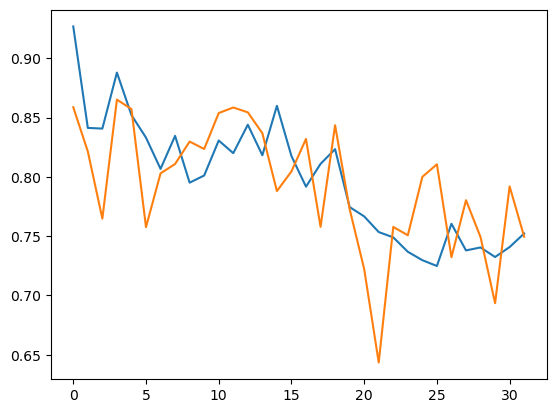

In [60]:
(pd.DataFrame(resultados)['preds']-0.02).plot()
pd.DataFrame(resultados)['y_test'].plot()

In [59]:
mean_squared_error(np.array(resultados['y_test']) , np.array(resultados['preds'])-0.03 )

0.002043054914265734

In [52]:
mean_squared_error(np.array(resultados['y_test'])* (pipe['TUPI'][1].data_range_[10]) + pipe['TUPI'][1].data_min_[10], np.array(resultados['preds'])* (pipe['TUPI'][1].data_range_[10]) + pipe['TUPI'][1].data_min_[10]) ** 0.5

272037.666048262